In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay

The data is from four categories:

- Spontaneous: 0
- Flashes: 1
- Static Gratings: 2
- Natural Scenes: 3

Constant Declaration

In [26]:
load_model = False

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

input_size = 93
output_dims = 8

data_dir = "stimulus_data/trimmed_data.csv"

num_epochs = 200

Using cuda device


Loading Data

In [27]:
data_df = pd.read_csv(data_dir)

class dataset(Dataset):
    def __init__(self, data_df):
        df = data_df.drop("stimulus", axis="columns")
        data = df.to_numpy()
        self.data = torch.tensor(data, dtype=torch.float)
    def __len__(self):
        return self.data.shape[0]
    def __getitem__(self, index):
        return self.data[index]

data = dataset(data_df)
labels = data_df["stimulus"].to_numpy()
train_dataloader = DataLoader(data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(data, batch_size=32, shuffle=False)

Model Creation

In [28]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 100),
            nn.ELU(),
            nn.Linear(100, 75),
            nn.ELU(),
            nn.Linear(75, 50),
            nn.ELU(),
            nn.Linear(50, 25),
            nn.ELU(),
            nn.Linear(25, output_dims),
            nn.ELU(),
            nn.Linear(output_dims, output_dims),
        )
        self.decoder = nn.Sequential(
            nn.Linear(output_dims, output_dims),
            nn.ELU(),
            nn.Linear(output_dims, 25),
            nn.ELU(),
            nn.Linear(25, 50),
            nn.ELU(),
            nn.Linear(50, 75),
            nn.ELU(),
            nn.Linear(75, 100),
            nn.ELU(),
            nn.Linear(100, input_size)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

Training Loop

In [29]:
def train(model, dataloader, loss_fn, optimizer, num_epochs=num_epochs):
    avg_losses = []

    model.train()
    model = model.to(device)

    pbar = tqdm(range(num_epochs))
    for i in pbar:
        total_loss = 0
        num = 0

        for data in dataloader:
            data = data.to(device)
            encoded, decoded = model(data)
            loss = loss_fn(decoded, data)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss
            num += 1

        avg_loss = (total_loss / num).detach().cpu().numpy()
        avg_losses.append(avg_loss)
        pbar.set_postfix_str(f"MSE Loss: {avg_loss}")

    return model, avg_losses

Evaluation

In [30]:
def score(model, classifier, dataloader, labels):
    model.eval()
    model = model.to(device)
    encodings = np.empty((1, output_dims))

    for data in dataloader:
        data = data.to(device)
        encoded, decoded = model(data)
        encoded = encoded.detach().cpu().numpy()
        encodings = np.append(encodings, encoded, axis=0)

    encodings = encodings[1:]

    clf = classifier()
    score = cross_val_score(clf, encodings, labels, scoring="accuracy", cv=5, n_jobs=-1)
    avg_score = score.mean()
    print(f"Average Accuracy: {avg_score}")
    return avg_score

def plot_confusion_matrix(model, classifier, dataloader, labels):
    model.eval()
    model = model.to(device)
    encodings = np.empty((1, output_dims))

    for data in dataloader:
        data = data.to(device)
        encoded, decoded = model(data)
        encoded = encoded.detach().cpu().numpy()
        encodings = np.append(encodings, encoded, axis=0)

    encodings = encodings[1:]

    clf = classifier()
    clf.fit(encodings, labels)
    ConfusionMatrixDisplay.from_estimator(clf, encodings, labels)
    plt.show()

def plot_losses(losses):
    plt.plot(losses)
    plt.xlabel("Epochs")
    plt.ylabel("Mean Squared Error")
    plt.title("Mean Squared Error vs. Epochs")
    plt.show()

Training and Evaluation

In [31]:
if(load_model):
    print("loading model from storage")
    model = torch.load("autoencoder.pth")
else:
    print("using new model")
    model = Autoencoder()

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

model, avg_losses = train(model, train_dataloader, loss_fn, optimizer, num_epochs)

using new model


100%|██████████| 200/200 [05:35<00:00,  1.68s/it, MSE Loss: 1.7349873781204224]


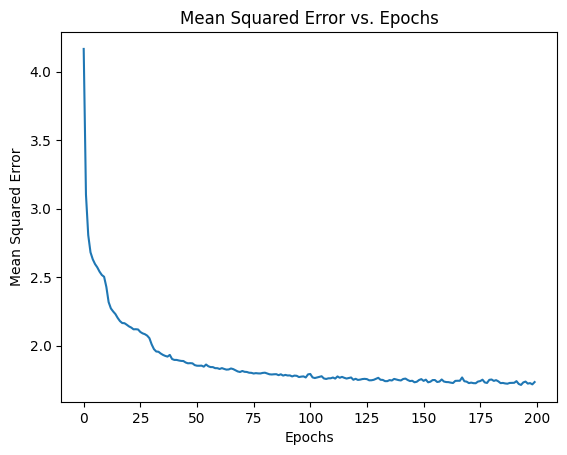

In [32]:
torch.save(model, "autoencoder.pth")
plot_losses(avg_losses)

Average Accuracy: 0.9253096221022548


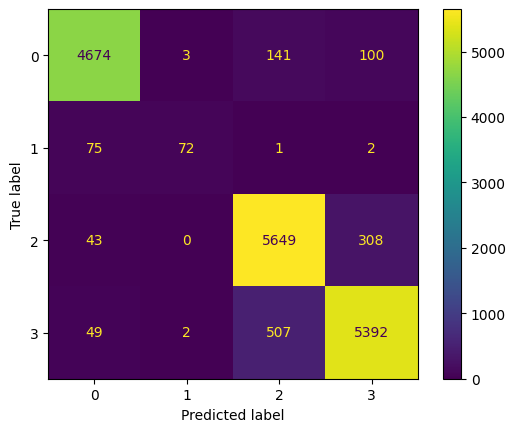

In [12]:
from sklearn.svm import SVC
avg_score = score(model, SVC, test_dataloader, labels)
plot_confusion_matrix(model, SVC, test_dataloader, labels)